In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

train = pd.read_csv('/kaggle/input/watermark/train.csv')

test = pd.read_csv('/kaggle/input/watermark/test.csv')

In [3]:
train.head()

,Image,Label
0,YGP5FW.jpg,0
1,R5BWPN.jpg,0
2,ESROUO.jpg,0
3,4CYU0L.jpg,0
4,3WG532.jpg,0


In [4]:
train_dir = '/kaggle/input/watermark/train'
test_dir = '/kaggle/input/watermark/test'

In [5]:
train.loc[train['Image'] == '4QLBJ8.jpg']

,Image,Label
2217,4QLBJ8.jpg,1


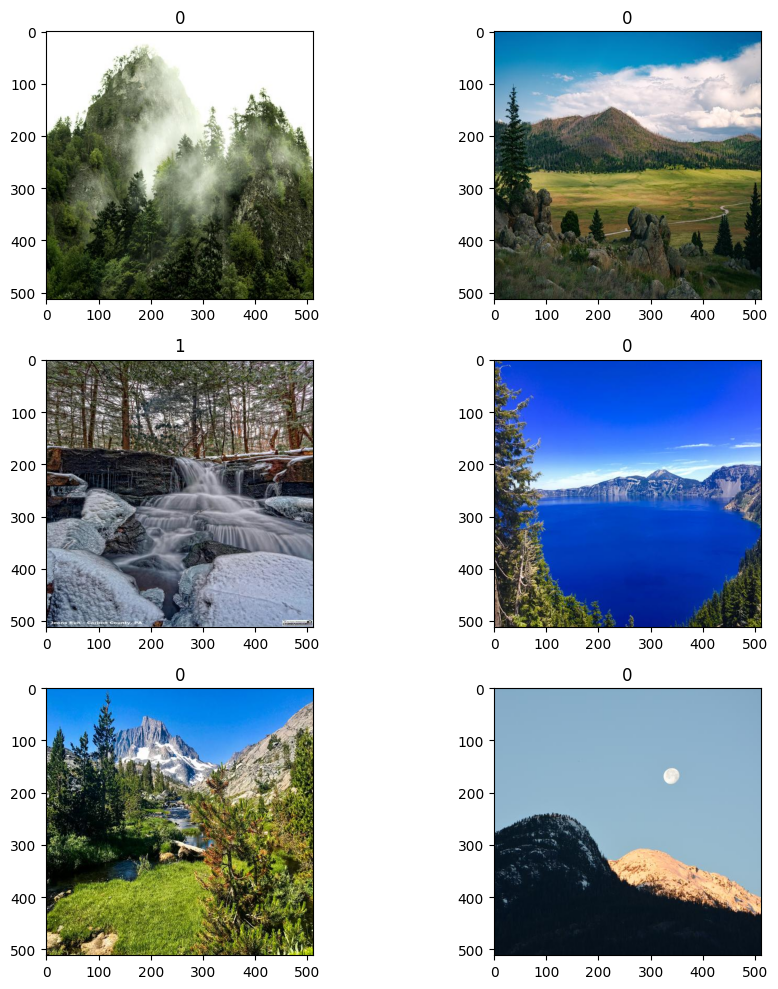

In [6]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Get a list of image filenames in the directory
image_files = os.listdir(train_dir)

# Randomly select 6 unique images
random_images = random.sample(image_files, 6)

# Create a subplot with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Display the selected images and their labels
for i, image_filename in enumerate(random_images):
    curr_image_path = os.path.join(train_dir, image_filename)
    
    # Load the image using PIL
    img = Image.open(curr_image_path)

    # Use conditional indexing to retrieve the value from 'Column_B'
    Image_Label = train.loc[train['Image'] == image_filename, 'Label'].values[0]

    # Determine the row and column for this image in the 3x2 grid
    row = i // 2
    col = i % 2
    
    # Plot the image on the corresponding subplot
    axes[row, col].imshow(img)
    # Set the title of the subplot to the image filename
    axes[row, col].set_title(Image_Label)
    
# Remove any empty subplots
for i in range(len(image_files), 6):
    row = i // 2
    col = i % 2
    fig.delaxes(axes[row, col])
    
# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

(512, 512)


Text(0.5, 1.0, 'Resized')

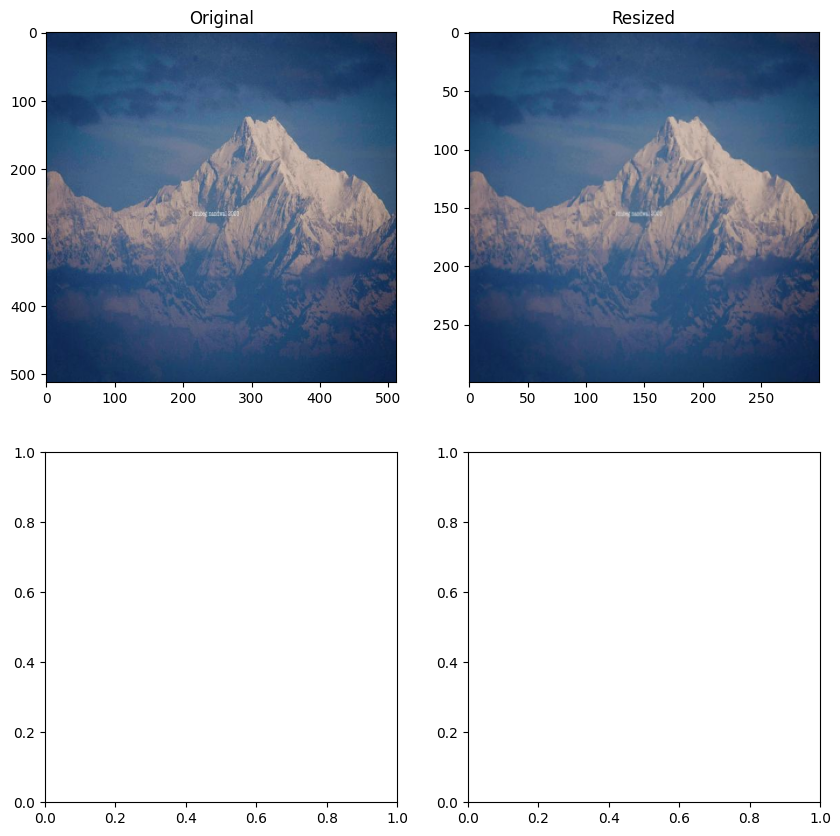

In [7]:
# Randomly select 6 unique images
random_images = random.sample(image_files, 1)[0]

# Create a subplot with 3 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

curr_image_path = os.path.join(train_dir, random_images)
    
# Load the image using PIL
img = Image.open(curr_image_path)
print(img.size)
# Use conditional indexing to retrieve the value from 'Column_B'
Image_Label = train.loc[train['Image'] == image_filename, 'Label'].values[0]

# Plot the image on the corresponding subplot
axes[0, 0].imshow(img)
# Set the title of the subplot to the image filename
axes[0, 0].set_title('Original')

img = img.resize((300,300))

# Plot the image on the corresponding subplot
axes[0, 1].imshow(img)
# Set the title of the subplot to the image filename
axes[0, 1].set_title('Resized')

In [8]:
pd.DataFrame(train.Label.value_counts())

,count
Label,
0,8961
1,6972


In [9]:
train.Label = train.Label.astype(str)
test.Label = test.Label.astype(str)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_dataframe(
                    dataframe=train,
                    directory=train_dir,
                    x_col="Image",
                    y_col="Label",
                    target_size=(300, 300),
                    batch_size=100,
                    class_mode="binary",
                    subset='training',
                    shuffle=True, 
                    seed = 1
)

val_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

val_generator = val_datagen.flow_from_dataframe(
                    dataframe=train,
                    directory=train_dir,
                    x_col="Image",
                    y_col="Label",
                    target_size=(300, 300),
                    batch_size=100,
                    class_mode="binary",
                    subset='validation',
                    shuffle=True,
                    seed = 1
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 11154 validated image filenames belonging to 2 classes.
Found 4779 validated image filenames belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = val_datagen.flow_from_dataframe(
                    dataframe=test,
                    directory=test_dir,
                    x_col="Image",
                    target_size=(300, 300),
                    batch_size=100,
                    class_mode=None
)

Found 6829 validated image filenames.


In [12]:
from keras.optimizers import RMSprop

In [13]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

def create_model(input_shape = (300,300, 3)):

    Inputs = L.Input(shape=input_shape)
    x = L.Conv2D(32, 3, padding="same")(Inputs)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Conv2D(64, 3, padding="same")(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Conv2D(64, 3, padding="same")(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Conv2D(128, 3, padding="same")(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Flatten()(x)
    x = L.Dense(512, activation="relu")(x)
    Outputs = L.Dense(1, activation="sigmoid")(x)

    model = Model(Inputs, Outputs)
    return model

In [14]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [15]:
with strategy.scope():
    model_1 = create_model()
    
model_1.compile(loss = "binary_crossentropy",
               optimizer=RMSprop(learning_rate=0.001),
               metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        36928 

In [16]:
history = model_1.fit(train_generator,
                    epochs=20,
                    steps_per_epoch = len(train_generator),
                    verbose=1,
                    validation_data = val_generator,
                    validation_steps = len(val_generator))

Epoch 1/20
112/112 [==============================] - 201s 2s/step - loss: 5.0640 - accuracy: 0.5566 - val_loss: 0.6803 - val_accuracy: 0.5618
Epoch 2/20
112/112 [==============================] - 103s 924ms/step - loss: 0.8070 - accuracy: 0.5663 - val_loss: 0.6801 - val_accuracy: 0.5719
Epoch 3/20
112/112 [==============================] - 99s 888ms/step - loss: 0.7819 - accuracy: 0.5637 - val_loss: 0.6790 - val_accuracy: 0.5677
Epoch 4/20
112/112 [==============================] - 98s 873ms/step - loss: 0.7958 - accuracy: 0.5693 - val_loss: 0.6762 - val_accuracy: 0.5794
Epoch 5/20
112/112 [==============================] - 97s 871ms/step - loss: 0.6871 - accuracy: 0.5721 - val_loss: 0.6743 - val_accuracy: 0.5738
Epoch 6/20
112/112 [==============================] - 99s 879ms/step - loss: 0.7079 - accuracy: 0.5833 - val_loss: 0.6662 - val_accuracy: 0.6054
Epoch 7/20
112/112 [==============================] - 98s 874ms/step - loss: 1.4985 - accuracy: 0.5907 - val_loss: 0.6621 - val_acc

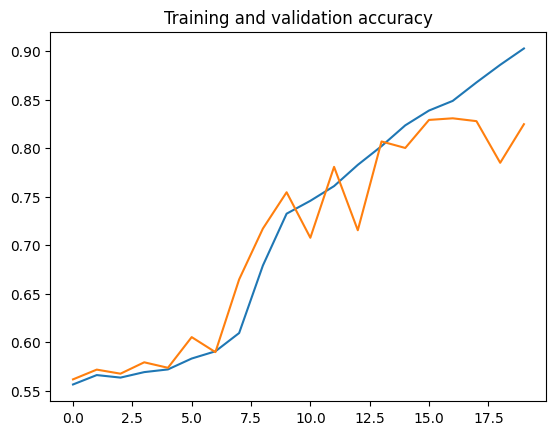

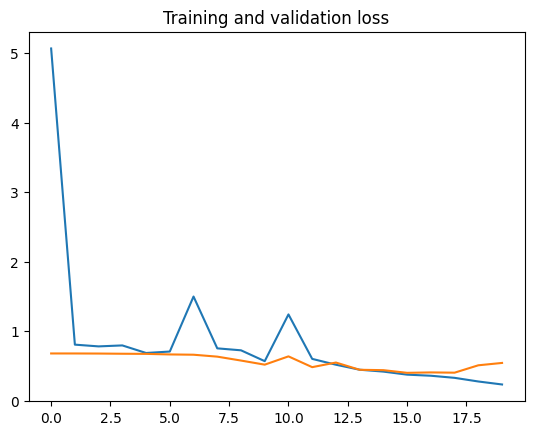

In [17]:
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


plt.plot( acc)
plt.plot( val_acc)
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(loss)
plt.plot( val_loss)


plt.title('Training and validation loss')
plt.show()

In [19]:
predictions = model_1.predict(test_generator)
predictions

69/69 [==============================] - 87s 1s/step


array([[0.00827973],
       [0.12547913],
       [0.9999989 ],
       ...,
       [0.00158627],
       [0.04508332],
       [1.        ]], dtype=float32)

In [26]:
my_list=[]
for pred in predictions:
    if pred >=0.5 :
        my_list.append(1)
    else :
        my_list.append(0)

In [27]:
submission= pd.DataFrame(my_list,columns=['Label'])
submission.head()

,Label
0,0
1,0
2,1
3,0
4,0


<Axes: xlabel='Label'>

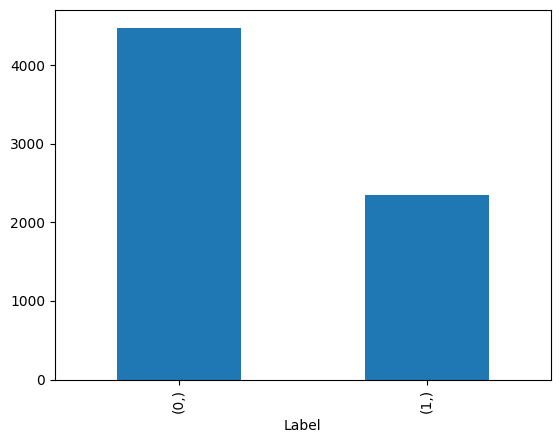

In [28]:
submission.value_counts().plot.bar()

In [30]:
# Specify the file path you want to delete
file_path = '/kaggle/working/sub.csv'

try:
    # Attempt to remove the file
    os.remove(file_path)
    print(f"{file_path} has been deleted successfully.")
except OSError as e:
    # Handle any errors, such as if the file doesn't exist
    print(f"Error: {e.filename} - {e.strerror}")

/kaggle/working/sub.csv has been deleted successfully.


In [31]:
submission.to_csv('/kaggle/working/sub.csv')